In [1]:
import gym
import numpy as np 

In [2]:
env = gym.make('Blackjack-v1', natural=False, sab=True)
num_actions = env.action_space.n

## ε-Soft Policy:

- Select a random action with probabilitε ε.
- Select the greedy action with probability 1-ε. |


In [3]:
def epsilon_soft_policy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        state_noOffset = state[0]-12, state[1]-1, int(state[2])
        return np.argmax(Q[state_noOffset])

## On Policy First Visit Monte Carlo Control
- state = (player's sum, dealer's face-up card, usable ace)
  - player's sum = 12 to 21 i.e (21-12+1) = 10 possible values
  - dealer's face-up card = 1 to 10 i.e 10 possible values

In [4]:
def on_policy_first_visit_mc_control(env, num_episodes, epsilon, gamma):
    Q = np.zeros((10, 10, 2, num_actions))
    N = np.zeros((32, 11, 2, num_actions))

    for episode in range(num_episodes):
        episode_data = []
        state, a = env.reset()
        # if player's sum is less than 12 then it is a hit
        terminated = False
        while state[0] < 12:
            state, reward, terminated, truncated, info = env.step(1)

        terminated = bool(terminated)
        
        while not terminated:
            action = epsilon_soft_policy(Q, state, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_data.append((state, action, reward))
            state = next_state

        G = 0
        
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G = gamma * G + reward
            if (state, action) not in [(x[0], x[1]) for x in episode_data[:t]]:
                state_noOffset = state[0]-12, state[1]-1, int(state[2])
                N[state_noOffset][action] += 1
                Q[state_noOffset][action] += (1 / N[state_noOffset][action]) * (G - Q[state_noOffset][action])
        
                
                
    return Q

In [27]:
num_episodes = 1000000
epsilon = 0.1
gamma = 1.0

optimal_Q = on_policy_first_visit_mc_control(env, num_episodes, epsilon, gamma)
optimal_policy = np.argmax(optimal_Q, axis=-1)

In [28]:
import matplotlib.pyplot as plt

In [29]:
# Plotting the optimal policy for usable and non-usable ace cases
usable_ace_policy = optimal_policy[:, :, 1]  # Usable ace
non_usable_ace_policy = optimal_policy[:, :, 0]  # Non-usable ace

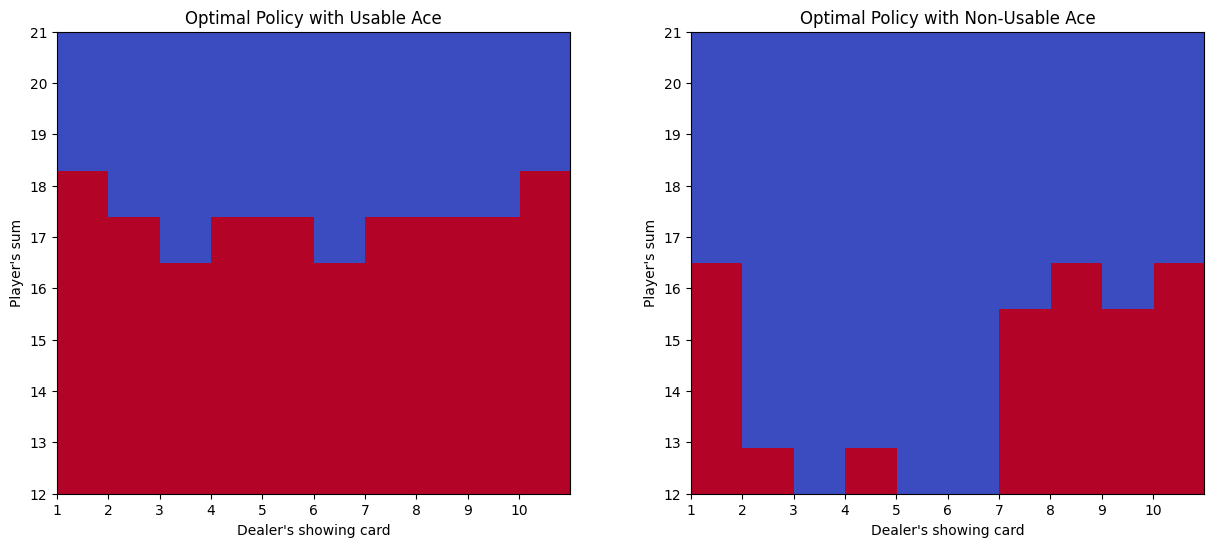

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for usable ace
axs[0].imshow(usable_ace_policy, origin='lower', cmap='coolwarm', extent=[1, 11, 12, 21])
axs[0].set_title('Optimal Policy with Usable Ace')
axs[0].set_xlabel("Dealer's showing card")
axs[0].set_ylabel("Player's sum")
axs[0].set_xticks(np.arange(1, 11, 1))
axs[0].set_yticks(np.arange(12, 22, 1))

# Plot for non-usable ace
axs[1].imshow(non_usable_ace_policy, origin='lower', cmap='coolwarm', extent=[1, 11, 12, 21])
axs[1].set_title('Optimal Policy with Non-Usable Ace')
axs[1].set_xlabel("Dealer's showing card")
axs[1].set_ylabel("Player's sum")
axs[1].set_xticks(np.arange(1, 11, 1))
axs[1].set_yticks(np.arange(12, 22, 1))

plt.show()